<!-- ## Gaussian Process Regression for Inverse Problems via MCMC

In many scientific and engineering applications, inverse problems arise when we seek to infer unknown input parameters of a system from observed output data. Formally, given a forward model $\Phi(u)$ that maps parameters $u \in U \subset \mathbb{R}^{d}$ to observations in $\mathbb{R}^q$, and noisy data $y$, the goal is to infer a distribution over $u$ such that:
$$
y = \Phi(u) + \eta, \quad \eta \sim \mathcal{N}(0, \sigma^2 I)
$$

Bayesian inference offers a principled framework to solve inverse problems by combining prior beliefs with observed data through Bayes' theorem:
$$
\mu^y(du) \propto \exp\left(-\frac{1}{2\sigma^2} \| y - \Phi(u) \|^2 \right) \mu_0(du)
$$
where $\mu^y$ is the posterior distribution and $\mu_0$ is the prior on the parameter space.

However, in practical settings, evaluating the forward model $\Phi$ can be computationally expensive. To reduce the computational cost in sampling from the posterior, a surrogate model such as a **Gaussian Process (GP)** can be used to approximate $\Phi$. Gaussian Processes offer a flexible, non-parametric approach to surrogate modeling, providing both mean predictions and uncertainty quantification.

### Delayed Acceptance MCMC with GP Surrogates

To maintain Bayesian correctness while improving efficiency, a two-stage **Delayed Acceptance (DA) MCMC** algorithm can be used:

1. **Surrogate Stage**: A computationally cheap GP approximation $\Phi_N \sim \mathcal{GP}(m_N(u), k_N(u, u'))$ is used to reject poor proposals early.
2. **Full Model Stage**: If the surrogate accepts the proposed sample, the expensive true model is evaluated to compute the full posterior acceptance probability.

This hierarchical structure reduces the number of expensive model evaluations, while preserving the correct target distribution in the limit.

In what follows, we demonstrate how to:
- Construct a GP surrogate from training data,
- Set up MCMC sampling for the inverse problem,
- Use Delayed Acceptance to accelerate convergence. -->

<!-- ## Advantages of Using Gaussian Processes for Inverse Problems

Gaussian Processes (GPs) are particularly well-suited as surrogate models in the context of Bayesian inverse problems. Their use enables efficient and flexible approximation of expensive forward models while preserving probabilistic structure. Below is a schematic summary of their key advantages:

### ✅ Flexibility and Non-parametric Modeling yet Simplicity
- GPs provide a flexible, non-parametric prior over functions.
- Capable of approximating highly nonlinear and non-smooth forward maps $\Phi(u)$ without needing explicit functional forms.

### ✅ Uncertainty Quantification
- Unlike deterministic surrogates, GPs return both a mean prediction and a variance.
- This built-in uncertainty can be propagated through the Bayesian posterior, improving robustness.

### ✅ Data Efficiency
- GPs are effective with limited training data due to their Bayesian nature.
- The model automatically adjusts its complexity based on the observed data.

### ✅ Theoretical Guarantees
- Under mild regularity conditions, the GP posterior mean converges to the true model in $L^2$, and so do the surrogate-induced posteriors (in Hellinger distance).
- Provides a solid foundation for using surrogates within Bayesian inversion.

### ? Online Learning


---

Together, these properties make Gaussian Processes a powerful tool for solving computationally intensive inverse problems in a principled, probabilistic framework. -->

In [1]:
import sys
sys.path.append(f"../../src/utils")

from preprocessing import preprocessing

import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import GPy

from onlineGP import *
from modelF import coarse_model
from scipy.stats.qmc import LatinHypercube
from scipy.stats import norm
import pickle

In [2]:
nsamples_train = 50
nsamples = 1000

num_dimensions = 3  # Number of parameters
seed = 449
sampler = LatinHypercube(d=3, seed=seed)
lhs_samples = sampler.random(n=nsamples)

# Scale the samples to the desired ranges for each parameter
param_ranges = [(0.1, 0.5), (-0.5, 0.5), (29, 31)]  # Define ranges for each parameter
random_parameters = lhs_samples.copy()
for i, (low, high) in enumerate(param_ranges):
    random_parameters[:, i] = low + (high - low) * lhs_samples[:, i]


In [3]:
# 1. Centro i dati
X_train = np.array([random_parameters[i] for i in range(nsamples_train)])
X_test = np.array([random_parameters[i] for i in range(nsamples_train, nsamples)])
Y_train = np.array([coarse_model(X_train[i]) for i in range(nsamples_train)])  # (640, 150)
Y_test = np.array([coarse_model(X_test[i]) for i in range(nsamples-nsamples_train)])  # (640, 150)

X_train_mean = np.mean(X_train, axis=0)
X_train_std = np.std(X_train, axis=0)
X_train_centered = (X_train - X_train_mean)/X_train_std
X_test_centered = (X_test - X_train_mean)/X_train_std

Y_min = np.min(Y_train)
Y_max = np.max(Y_train)
Y_std = Y_max - Y_min
Y_centered = (Y_train - Y_min)/Y_std
Y_centered_test = (Y_test - Y_min)/Y_std

# 2. SVD
U, s, VT = np.linalg.svd(Y_centered.T, full_matrices=False)

print(U.shape)
# 3. Scegli il rank
r = 5 # puoi cambiare
Z_r = U[:,:r]
s_r = s[:r]
V_r = VT[:r, :]          # (r, 150)

# 4. Ricostruzione del segnale i-esimo
i = 7 # scegli quale segnale visualizzare
y_true = Y_centered_test[i, :]               # segnale originale centrato
y_reconstructed = Z_r @ Z_r.T @ y_true.T       # ricostruzione centrata

# 5. Aggiungo la media a entrambi
y_true *= 1
y_reconstructed *= 1
y_true += 0
y_reconstructed += 0

print(np.sqrt(np.mean((Y_centered.T -  Z_r @ Z_r.T @ Y_centered.T  ) ** 2)))

np.savez(f"data/gp_svd_decomposition_{nsamples_train}.npz",
         Z_r=Z_r,
         V_r=V_r,
         s_r=s_r,
         Y_min=Y_min,
         Y_centered=Y_centered,
         Y_std=Y_std,
         X_mean=X_train_mean,
         X_std=X_train_std)


(150, 50)
7.97536920352592e-05


 <>:6: SyntaxWarning:invalid escape sequence '\D'
 <>:6: SyntaxWarning:invalid escape sequence '\D'
 /var/folders/4s/l1d335rn5k19twqx3g8v_9140000gn/T/ipykernel_15703/3322190253.py:6: SyntaxWarning:invalid escape sequence '\D'


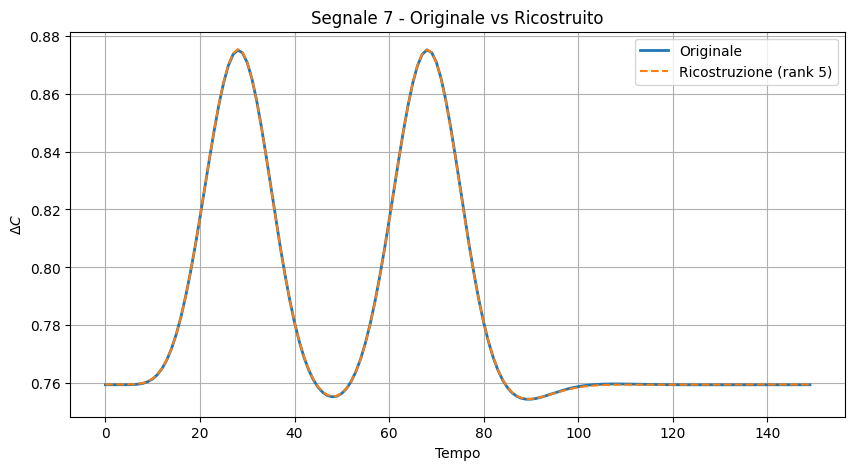

In [4]:
# 6. Plot
plt.figure(figsize=(10, 5))
plt.plot(y_true, label='Originale', linewidth=2)
plt.plot(y_reconstructed, '--', label=f'Ricostruzione (rank {r})')
plt.xlabel('Tempo')
plt.ylabel(f'$\Delta C$')
plt.title(f'Segnale {i} - Originale vs Ricostruito')
plt.legend()
plt.grid()
plt.show()

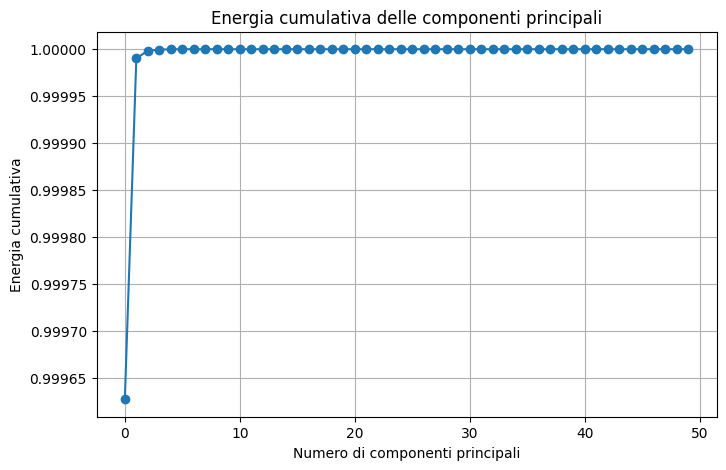

In [5]:
# Calcolo dell'energia cumulativa
cumulative_energy = np.cumsum(s**2) / np.sum(s**2)

plt.figure(figsize=(8, 5))
plt.plot(cumulative_energy, 'o-')
# plt.yscale( 'log')
plt.xlabel('Numero di componenti principali')
plt.ylabel('Energia cumulativa')
plt.title('Energia cumulativa delle componenti principali')
plt.grid(True)
plt.show()

In [6]:
# r = 5
# V_target = (s_r[np.newaxis,:] * V_r.T)  # (640, r)
# GP_models = []

# for j in range(Z_r.shape[1]):  # per ogni componente ridotta (z_j)
#     v_j = V_target[:,j].reshape(-1, 1)  # Output da modellare
#     kernel = GPy.kern.RBF(input_dim=X_train_centered.shape[1], ARD=True)
#     model = GPy.models.GPRegression(X_train_centered, v_j, kernel)
#     model.optimize(messages=False)
#     GP_models.append(model)


In [7]:
# import pickle

# # Salva i modelli nella cartella di Google Drive
# for t in range(len(GP_models)):  # Per tutti i time steps (modelli)
#     # Open the file in binary write mode ('wb') and specify encoding
#     with open(f"./SVD_GP_models/GP_models_gpy_{t}_{nsamples_train}.pkl", 'wb') as f:
#         # Save the model using pickle.dump() with encoding
#         pickle.dump(GP_models[t], f, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

In [8]:
# # Carica tutti i modelli usando load_model
# GP_models_loaded = []
# for t in range(len(GP_models)):  # Per tutti i time steps
#     # Open the file in binary read mode ('rb')
#     with open(f"./SVD_GP_models/GP_models_gpy_{t}_{nsamples_train}.pkl", 'rb') as f:
#         # Load the model using pickle.load() with encoding
#         model = pickle.load(f, fix_imports=True, encoding='latin1')
#     GP_models_loaded.append(model)

In [9]:
# A = np.load(f"gp_svd_decomposition_{nsamples}.npz", allow_pickle=True)
# Z_r = A['Z_r']  # (640, r)
# Y_min = A['Y_min']
# Y_std = A['Y_std']

# for i in range(3):
#     sample_index = i
#     sample_input = X_test_centered[sample_index].reshape(1, -1)

#     z_pred = []
#     z_std = []

#     for model in GP_models_loaded:
#         mu, sigma = model.predict(sample_input)
#         z_pred.append(mu.item())
#         z_std.append(sigma.item())

#     z_pred = np.array(z_pred)  # (r,)
#     z_std = np.array(z_std)    # (r,)
#     print(z_std)
#     y_pred = Y_std*(Z_r @ z_pred) + Y_min  # (150,)

#     # Note: covariance in signal space: Cov_y ≈ Z_r @ diag(var_z) @ Z_r^T
#     cov_y = Z_r @ np.diag(z_std**2) @ Z_r.T * (Y_std**2)        # (150, 150)
#     y_std = np.sqrt(np.diag(cov_y))                # standard deviation at each time step

#     y_upper = y_pred + 2 * y_std
#     y_lower = y_pred - 2 * y_std

#     time = np.arange(y_pred.shape[0])

#     plt.figure(figsize=(5, 3))
#     plt.plot(time, y_pred, label="Predicted Output", color='blue')
#     plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
#     if Y_test is not None:
#         plt.scatter(time, Y_test[sample_index], label="Actual Output", color='red', s=10)
#     plt.xlabel("Time")
#     plt.ylabel("Output Value")
#     plt.title("Predicted vs Actual Signal with Confidence Bounds")
#     plt.legend()
#     plt.grid(True)
#     plt.tight_layout()
#     plt.show()

In [10]:
# r = 5
# V_target = (s_r[np.newaxis,:] * V_r.T)  # (640, r)
# print("V_r", V_r.shape)
# GP_models = []

# for j in range(Z_r.shape[1]):  # per ogni componente ridotta (z_j)
#     v_j = V_target[:,j].reshape(-1, 1)  # Output da modellare
#     print("v_j", v_j.shape)
#     model = ARDRBFGaussianProcess(init_scales=np.array([1.0,1.0,0.01]),reg=1e-6)
#     model.fit(X_train_centered, v_j,optimize_scales=True)
#     GP_models.append(model)
    
# model.predict(X_test_centered)[0].shape


In [11]:
# import pickle

# # Salva i modelli nella cartella di Google Drive
# for t in range(len(GP_models)):  # Per tutti i time steps (modelli)
#     # Open the file in binary write mode ('wb') and specify encoding
#     with open(f"./SVD_GP_models/GP_models_ardrbf_{t}_{nsamples_train}.pkl", 'wb') as f:
#         # Save the model using pickle.dump() with encoding
#         pickle.dump(GP_models[t], f, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

In [12]:
# Carica tutti i modelli usando load_model
GP_models_loaded = []
for t in range(5):  # Per tutti i time steps
    # Open the file in binary read mode ('rb')
    with open(f"./SVD_GP_models/GP_models_ardrbf_{t}_{nsamples_train}.pkl", 'rb') as f:
        # Load the model using pickle.load() with encoding
        model = pickle.load(f, fix_imports=True, encoding='latin1')
    GP_models_loaded.append(model)

[6.07106605e-03 5.23369199e-04 1.14823679e-05 8.36241812e-06
 3.99015348e-06]


 <>:38: SyntaxWarning:invalid escape sequence '\D'
 <>:38: SyntaxWarning:invalid escape sequence '\D'
 /var/folders/4s/l1d335rn5k19twqx3g8v_9140000gn/T/ipykernel_15703/3342598042.py:38: SyntaxWarning:invalid escape sequence '\D'


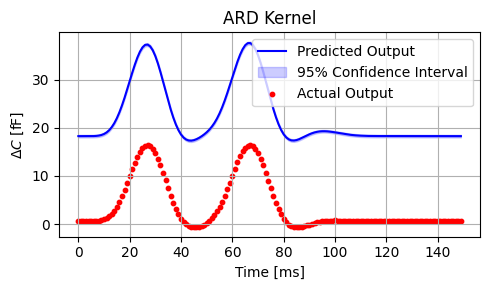

[4.06962598e-04 2.69664687e-05 1.86888568e-06 9.84603406e-07
 7.64458878e-07]


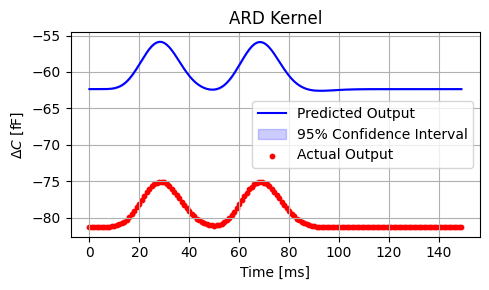

[9.28509426e-05 4.69046315e-06 6.50685466e-07 3.42513468e-07
 3.17427799e-07]


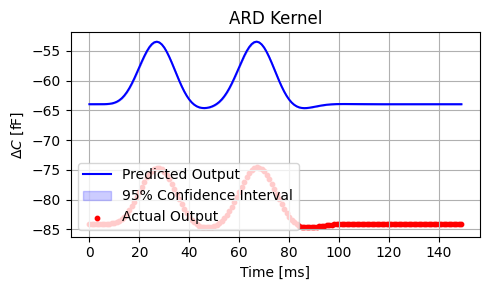

In [13]:
A = np.load(f"gp_svd_decomposition_{nsamples_train}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
Y_min = A['Y_min']
Y_std = A['Y_std']

for i in range(3):
    sample_index = i
    sample_input = X_test_centered[sample_index].reshape(1, -1)

    z_pred = []
    z_std = []

    for model in GP_models_loaded:
        mu, sigma = model.predict(sample_input)
        z_pred.append(mu.item())
        z_std.append(sigma.item())

    z_pred = np.array(z_pred)  # (r,)
    z_std = np.array(z_std)    # (r,)
    print(z_std)
    y_pred = Y_std*(Z_r @ z_pred) + Y_min  # (150,)

    # Note: covariance in signal space: Cov_y ≈ Z_r @ diag(var_z) @ Z_r^T
    cov_y = Z_r @ np.diag((z_std)**2) @ Z_r.T        # (150, 150)
    y_std = np.sqrt(np.diag(cov_y)*(Y_std**2))                # standard deviation at each time step

    y_upper = y_pred + 2 * y_std  
    y_lower = y_pred - 2 * y_std 

    time = np.arange(y_pred.shape[0])

    plt.figure(figsize=(5, 3))
    plt.plot(time, y_pred, label="Predicted Output", color='blue')
    plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
    if Y_test is not None:
        plt.scatter(time, Y_test[sample_index], label="Actual Output", color='red', s=10)
    plt.xlabel("Time [ms]")
    plt.ylabel(f"$\Delta C$ [fF]" )
    plt.title("ARD Kernel")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [14]:
# r = 5
# V_target = (s_r[np.newaxis,:] * VT[:r,:].T)  # (640, r)

# print("V_r", V_r.shape)
# GP_models = []

# for j in range(Z_r.shape[1]):  # per ogni componente ridotta (z_j)
#     v_j = V_target[:,j].reshape(-1, 1)  # Output da modellare
#     model = RBFGaussianProcess(reg=1e-6)
#     model.fit(X_train_centered, v_j)
#     GP_models.append(model)
    


In [15]:
# import pickle

# # Salva i modelli nella cartella di Google Drive
# for t in range(len(GP_models)):  # Per tutti i time steps (modelli)
#     # Open the file in binary write mode ('wb') and specify encoding
#     with open(f"./SVD_GP_models/GP_models_rbf_{t}_{nsamples_train}.pkl", 'wb') as f:
#         # Save the model using pickle.dump() with encoding
#         pickle.dump(GP_models[t], f, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

In [16]:
# Carica tutti i modelli usando load_model
GP_models_loaded = []
for t in range(5):  # Per tutti iz time steps
    # Open the file in binary read mode ('rb')
    with open(f"./SVD_GP_models/GP_models_rbf_{t}_{nsamples_train}.pkl", 'rb') as f:
        # Load the model using pickle.load() with encoding
        model = pickle.load(f, fix_imports=True, encoding='latin1')
    GP_models_loaded.append(model)

[0.68778743 0.68778743 0.68778743 0.68778743 0.68778743]


 <>:38: SyntaxWarning:invalid escape sequence '\D'
 <>:38: SyntaxWarning:invalid escape sequence '\D'
 /var/folders/4s/l1d335rn5k19twqx3g8v_9140000gn/T/ipykernel_15703/3510933007.py:38: SyntaxWarning:invalid escape sequence '\D'


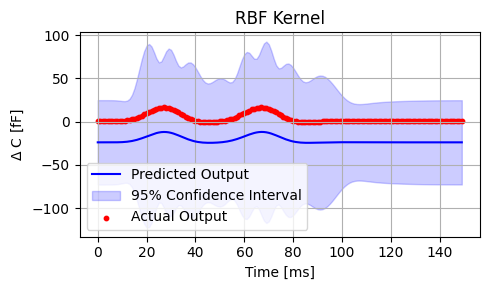

[0.25906349 0.25906349 0.25906349 0.25906349 0.25906349]


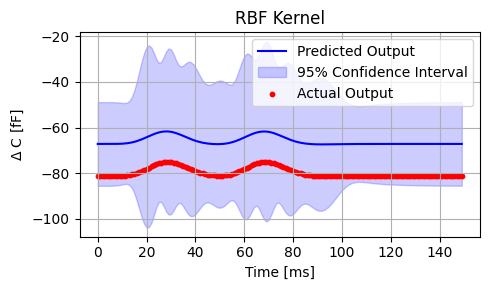

[0.17244109 0.17244109 0.17244109 0.17244109 0.17244109]


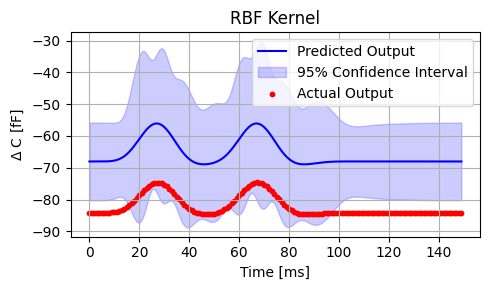

In [17]:
A = np.load(f"gp_svd_decomposition_{nsamples_train}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
Y_min = A['Y_min']
Y_std = A['Y_std']

for i in range(3):
    sample_index = i
    sample_input = X_test_centered[sample_index].reshape(1, -1)

    z_pred = []
    z_std = []

    for model in GP_models_loaded:
        mu, sigma = model.predict(sample_input)
        z_pred.append(mu.item())
        z_std.append(sigma.item())

    z_pred = np.array(z_pred)  # (r,)
    z_std = np.array(z_std)    # (r,)
    print(z_std)
    y_pred = Y_std*(Z_r @ z_pred) + Y_min  # (150,)

    # Note: covariance in signal space: Cov_y ≈ Z_r @ diag(var_z) @ Z_r^T
    cov_y = Z_r @ np.diag(z_std**2) @ Z_r.T         # (150, 150)
    y_std = np.sqrt(np.diag(cov_y))*Y_std                # standard deviation at each time step

    y_upper = y_pred + 2 * y_std
    y_lower = y_pred - 2 * y_std

    time = np.arange(y_pred.shape[0])

    plt.figure(figsize=(5, 3))
    plt.plot(time, y_pred, label="Predicted Output", color='blue')
    plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
    if Y_test is not None:
        plt.scatter(time, Y_test[sample_index], label="Actual Output", color='red', s=10)
    plt.xlabel("Time [ms]")
    plt.ylabel("$\Delta$ C [fF]" )
    plt.title("RBF Kernel")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [18]:
r = 5
V_target = (s_r[np.newaxis,:] * V_r.T)  # (640, r)
print("V_r", V_r.shape)
GP_models = []

for j in range(Z_r.shape[1]):  # per ogni componente ridotta (z_j)
    v_j = V_target[:,j].reshape(-1, 1)  # Output da modellare
    print("v_j", v_j.shape)
    model = ARDMatern52GaussianProcess(init_scales=np.array([1.0,1.0,0.01]),reg=3e-5)
    model.fit(X_train_centered, v_j,optimize_scales=True)
    GP_models.append(model)
    
model.predict(X_test_centered)[0].shape

V_r (5, 50)
v_j (50, 1)


KeyboardInterrupt: 

In [ ]:
import pickle

# Salva i modelli nella cartella di Google Drive
for t in range(len(GP_models)):  # Per tutti i time steps (modelli)
    # Open the file in binary write mode ('wb') and specify encoding
    with open(f"./SVD_GP_models/GP_models_matern_{t}_{nsamples_train}.pkl", 'wb') as f:
        # Save the model using pickle.dump() with encoding
        pickle.dump(GP_models[t], f, protocol=pickle.HIGHEST_PROTOCOL, fix_imports=True)

In [ ]:
# Carica tutti i modelli usando load_model
GP_models_loaded = []
for t in range(5):  # Per tutti iz time steps
    # Open the file in binary read mode ('rb')
    with open(f"./SVD_GP_models/GP_models_matern_{t}_{nsamples_train}.pkl", 'rb') as f:
        # Load the model using pickle.load() with encoding
        model = pickle.load(f, fix_imports=True, encoding='latin1')
    GP_models_loaded.append(model)

In [ ]:
from sklearn.metrics import pairwise_distances

# Compute distance matrix between test points
dists = pairwise_distances(X_test_centered)

# Mask diagonal
np.fill_diagonal(dists, -np.inf)

# Find the most distant pair (i, j)
I, J = np.unravel_index(np.argmax(dists), dists.shape)
X_a_centered = X_test_centered[I]
X_b_centered = X_test_centered[J]

X_a = X_test[I]
X_b = X_test[J]
print(f"Selected test points: {I} and {J}")

Selected test points: 624 and 782


[0.02496561984105677, 0.006761373503549214, 0.005162703116615228, 0.005162703116615228, 0.005162703116615228]


 <>:40: SyntaxWarning:invalid escape sequence '\D'
 <>:40: SyntaxWarning:invalid escape sequence '\D'
 /var/folders/4s/l1d335rn5k19twqx3g8v_9140000gn/T/ipykernel_15159/3773028914.py:40: SyntaxWarning:invalid escape sequence '\D'


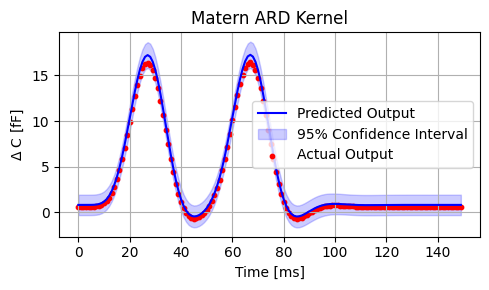

[0.04876589604386306, 0.009184454537137371, 0.005314080754258399, 0.005314080754258399, 0.005314080754258399]


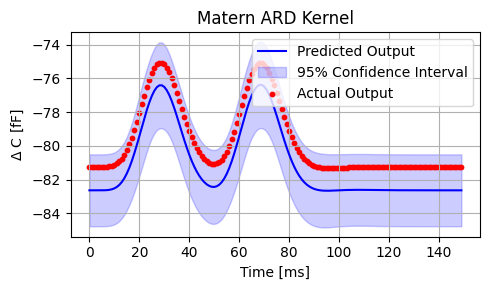

[0.06199947190092623, 0.010362662204789085, 0.006252489662966994, 0.006252489662966994, 0.006252489662966994]


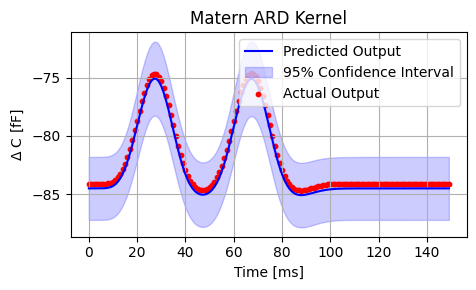

In [ ]:
A = np.load(f"data/gp_svd_decomposition_{nsamples_train}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
Y_min = A['Y_min']
Y_std = A['Y_std']

for i in range(3):
    sample_index = i
    sample_input = X_test_centered[sample_index].reshape(1, -1)

    z_pred = []
    z_std = []

    for model in GP_models_loaded:
        mu, sigma = model.predict(sample_input)
        z_pred.append(mu.item())
        z_std.append(sigma.item())
    print(z_std)
    z_pred = np.array(z_pred)  # (r,)
    z_std = np.array(z_std)    # (r,)
    y_pred = Y_std*(Z_r @ z_pred) + Y_min  # (150,)

    # Note: covariance in signal space: Cov_y ≈ Z_r @ diag(var_z) @ Z_r^T
    cov_y = Z_r @ np.diag(z_std**2) @ Z_r.T         # (150, 150)
    y_std = np.sqrt(np.diag(cov_y))*Y_std                # standard deviation at each time step

    confidence_level = 0.95
    z_score = norm.ppf((1 + confidence_level) / 2)

    y_upper = y_pred + z_score * y_std
    y_lower = y_pred - z_score * y_std

    time = np.arange(y_pred.shape[0])

    plt.figure(figsize=(5, 3))
    plt.plot(time, y_pred, label="Predicted Output", color='blue')
    plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
    if Y_test is not None:
        plt.scatter(time, Y_test[sample_index], label="Actual Output", color='red', s=10)
    plt.xlabel("Time [ms]")
    plt.ylabel(f"$\Delta$ C [fF]" )
    plt.title("Matern ARD Kernel")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
# Generate N_ref points near X_a
N_ref = 10
eps = 0.01  # small radius

X_ref = X_a + eps * np.random.randn(N_ref, X_test.shape[1])
X_ref_centered = (X_ref - X_train_mean) / X_train_std

# Simulate POD coefficients via ground truth (or true model)
# We simulate this by taking the projection of the true signal
true_signal = np.array([coarse_model(X_ref[i]) for i in range(N_ref)])  # (N_ref, 150)
z_ref = ((true_signal - Y_min) / Y_std) @ Z_r  # project to latent

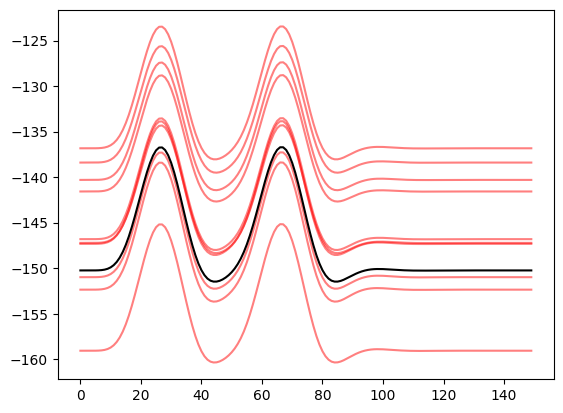

In [ ]:
plt.plot(true_signal.T,'r', alpha=0.5)
plt.plot(Y_test[I].T,'k')

In [ ]:
print(z_ref.shape)

(10, 5)


In [ ]:
for d, model in enumerate(GP_models_loaded):
    # For each POD mode, update with one column of Z_ref
    model.fit(X_ref_centered, z_ref[:, d].reshape(-1, 1), optimize_scales=True)

1360557.2343752196
1996056.511515177
2076987.699680467
2076987.699680467
2076987.699680467


[ 0.19472481 -0.36120219 30.14152041]
[0.00214598 0.00187417 0.00179236 0.00179236 0.00179236]


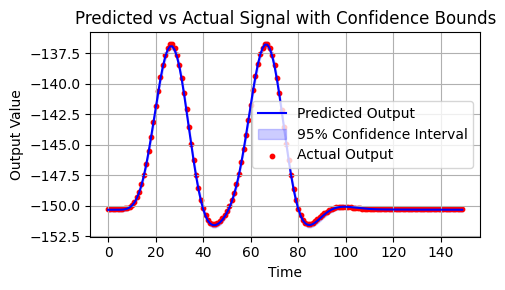

[ 0.1104831  -0.47160102 30.95254491]
[0.14320216 0.03599574 0.0230124  0.0230124  0.0230124 ]


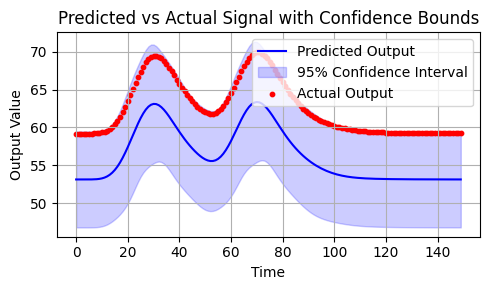

In [ ]:
A = np.load(f"data/gp_svd_decomposition_{nsamples_train}.npz", allow_pickle=True)
Z_r = A['Z_r']  # (640, r)
Y_min = A['Y_min']
Y_std = A['Y_std']

for i in [I,J]:
    print(X_test[sample_index])
    sample_index = i
    sample_input = X_test_centered[sample_index].reshape(1, -1)

    z_pred = []
    z_std = []

    for model in GP_models_loaded:
        mu, sigma = model.predict(sample_input)
        z_pred.append(mu.item())
        z_std.append(sigma.item())

    z_pred = np.array(z_pred)  # (r,)
    z_std = np.array(z_std)    # (r,)
    print(z_std)
    y_pred = Y_std*(Z_r @ z_pred) + Y_min  # (150,)

    # Note: covariance in signal space: Cov_y ≈ Z_r @ diag(var_z) @ Z_r^T
    cov_y = Z_r @ np.diag(z_std**2) @ Z_r.T         # (150, 150)
    y_std = np.sqrt(np.diag(cov_y))*Y_std                # standard deviation at each time step

    confidence_level = 0.95
    z_score = norm.ppf((1 + confidence_level) / 2)

    y_upper = y_pred + z_score * y_std
    y_lower = y_pred - z_score * y_std

    time = np.arange(y_pred.shape[0])

    plt.figure(figsize=(5, 3))
    plt.plot(time, y_pred, label="Predicted Output", color='blue')
    plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Confidence Interval")
    if Y_test is not None:
        plt.scatter(time, Y_test[sample_index], label="Actual Output", color='red', s=10)
    plt.xlabel("Time")
    plt.ylabel("Output Value")
    plt.title("Predicted vs Actual Signal with Confidence Bounds")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Input location: [ 0.1104831  -0.47160102 30.95254491]


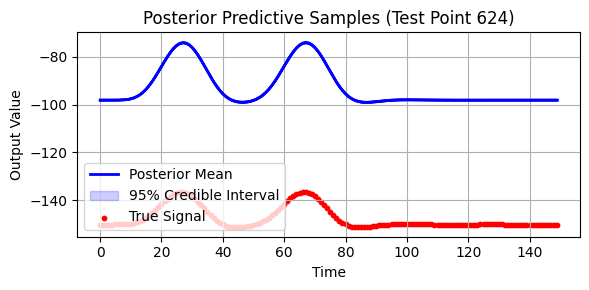

Input location: [ 0.49581876  0.49987625 29.09109819]


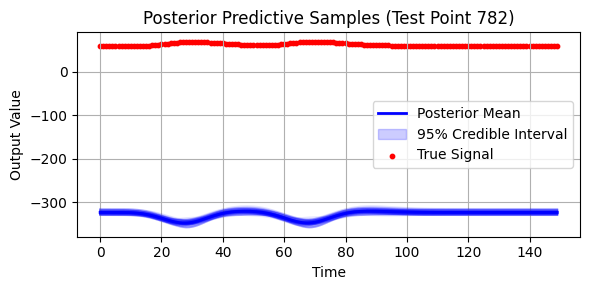

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Load SVD decomposition
A = np.load(f"gp_svd_decomposition_{nsamples}.npz", allow_pickle=True)
Z_r = A['Z_r']       # (640, r)
Y_min = A['Y_min']   # (150,)
Y_std = A['Y_std']   # (150,)

# Number of posterior samples
n_samples = 50

for i in [I, J]:
    print("Input location:", X_test[i])
    sample_input = X_test_centered[i].reshape(1, -1)

    # GP predictions
    z_mean = []
    z_std = []

    for model in GP_models_loaded:
        mu, sigma = model.predict(sample_input)
        z_mean.append(mu.item())
        z_std.append(sigma.item())

    z_mean = np.array(z_mean)
    z_std = np.array(z_std)
    
    # Sample from posterior in latent space
    z_samples = np.random.normal(loc=z_mean, scale=z_std, size=(n_samples, len(z_mean)))

    # Reconstruct in signal space: y = Z_r @ z (normalized)
    y_samples = (Z_r @ z_samples.T).T  # shape (n_samples, 150)
    y_samples = y_samples * Y_std + Y_min  # unnormalize

    # Mean and percentile bands
    y_pred = np.mean(y_samples, axis=0)
    time = np.arange(y_pred.shape[0])
    
    y_lower = np.percentile(y_samples, 2.5, axis=0)
    y_upper = np.percentile(y_samples, 97.5, axis=0)

    # Plotting
    plt.figure(figsize=(6, 3))
    for y in y_samples:
        plt.plot(time, y, color='blue', alpha=0.1)

    plt.plot(time, y_pred, color='blue', linewidth=2, label="Posterior Mean")
    plt.fill_between(time, y_lower, y_upper, color='blue', alpha=0.2, label="95% Credible Interval")

    if Y_test is not None:
        plt.scatter(time, Y_test[i], label="True Signal", color='red', s=10)

    plt.xlabel("Time")
    plt.ylabel("Output Value")
    plt.title(f"Posterior Predictive Samples (Test Point {i})")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Text(0.5, 1.0, 'POD Modes')

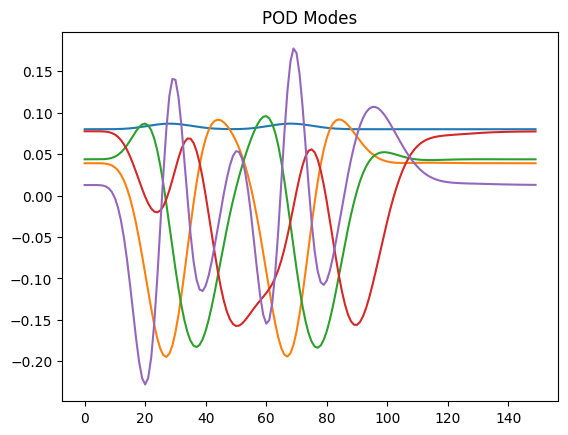

In [ ]:
plt.plot(Z_r[:,0])
plt.plot(Z_r[:,1])
plt.plot(Z_r[:,2]) 
plt.plot(Z_r[:,3])
plt.plot(Z_r[:,4])
plt.title("POD Modes") 

Loading models for sample size: 10
Loading models for sample size: 20
Loading models for sample size: 50
Loading models for sample size: 100
Loading models for sample size: 150
Loading models for sample size: 200
Loading models for sample size: 250
Loading models for sample size: 300
Loading models for sample size: 640


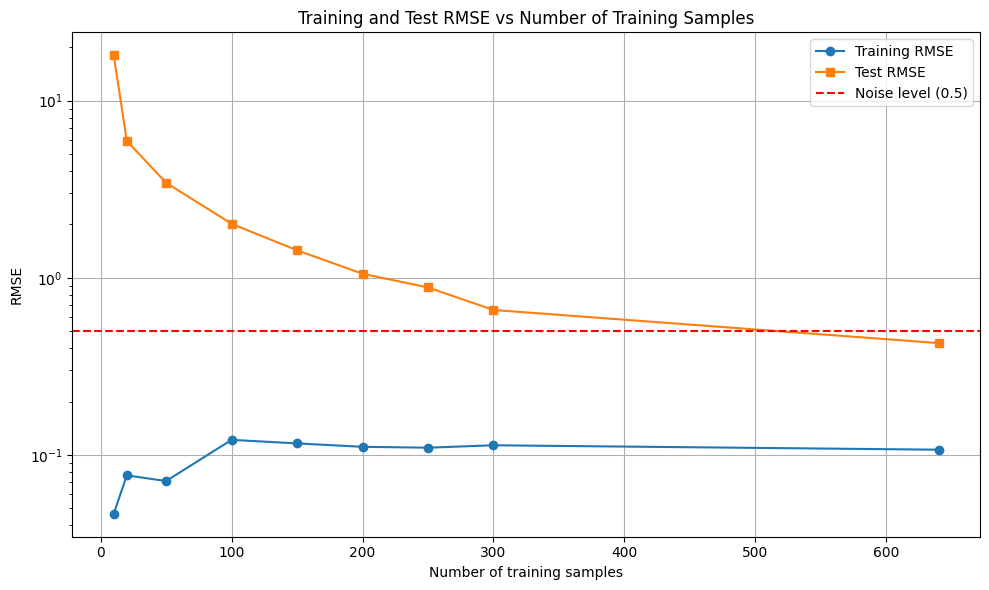

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

# List of training sample sizes
sample_sizes = [10, 20, 50, 100, 150, 200, 250, 300, 640]

# Arrays to store errors
train_errors = []
test_errors = []

# Paths to data and models
gp_model_dir = "./SVD_GP_models"

# Assuming these variables are already defined
# X_train, Y_train, X_test, Y_test

def compute_rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

for nsamples in sample_sizes:
    print(f"Loading models for sample size: {nsamples}")

    X_train = np.array([random_parameters[i] for i in range(nsamples)])
    X_test = np.array([random_parameters[i] for i in range(nsamples, 1000)])
    Y_train = np.array([coarse_model(X_train[i]) for i in range(nsamples)])  # (640, 150)
    Y_test = np.array([coarse_model(X_test[i]) for i in range(-nsamples+1000)])  # (640, 150)

    X_train_mean = np.mean(X_train, axis=0)
    X_train_std = np.std(X_train, axis=0)
    X_train_centered = (X_train - X_train_mean)/X_train_std
    X_test_centered = (X_test - X_train_mean)/X_train_std

    Y_min = np.min(Y_train)
    Y_max = np.max(Y_train)
    Y_std = Y_max - Y_min
    Y_centered = (Y_train - Y_min)/Y_std
    Y_centered_test = (Y_test - Y_min)/Y_std

    # Load GP models
    GP_models_loaded = []
    for t in range(5):  # assuming 5 GP models (latent dimensions)
        model_file = os.path.join(gp_model_dir, f"GP_models_matern_{t}_{nsamples}.pkl")
        with open(model_file, 'rb') as f:
            GP_models_loaded.append(pickle.load(f))

    A = np.load(f"data/gp_svd_decomposition_{nsamples}.npz", allow_pickle=True)

    # Predictions on training set
    Y_train_pred = np.array([
        model.predict(X_train_centered)[0].ravel() for model in GP_models_loaded
    ]).T
    
    Z_r = A['Z_r']  # (640, r)
    Y_min = A['Y_min']
    Y_std = A['Y_std']

    # Predictions on test set
    Y_test_pred = np.array([
        model.predict(X_test_centered)[0].ravel() for model in GP_models_loaded
    ]).T

    # Compute RMSE for train and test
    train_rmse = compute_rmse(Y_train, (Z_r @ Y_train_pred.T).T*Y_std + Y_min)
    test_rmse = compute_rmse(Y_test, (Z_r @ Y_test_pred.T).T*Y_std + Y_min)

    train_errors.append(train_rmse)
    test_errors.append(test_rmse)


plt.figure(figsize=(10, 6))
plt.plot(sample_sizes, train_errors, 'o-', label='Training RMSE')
plt.plot(sample_sizes, test_errors, 's-', label='Test RMSE')
# Add horizontal noise reference line
plt.axhline(y=0.5, color='r', linestyle='--', label='Noise level (0.5)')

plt.yscale('log')
plt.xlabel("Number of training samples")
plt.ylabel("RMSE")
plt.title("Training and Test RMSE vs Number of Training Samples")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [24]:
import imageio
import os

# Parameters
output_file = "gp_refinement_animation.gif"
frame_dir = "."  # or wherever your PNGs are saved
frame_pattern = "iteration_f_{}.png"
frame_indices = range(0, 22)  # from 0 to 20
duration_per_frame = 0.5  # seconds

# Collect images
images = []
for i in frame_indices:
    frame_path = os.path.join(frame_dir, frame_pattern.format(i))
    if os.path.exists(frame_path):
        images.append(imageio.imread(frame_path))
    else:
        print(f"⚠️ Warning: {frame_path} not found.")

# Create gif
imageio.mimsave(output_file, images, duration=duration_per_frame)
print(f"✅ Saved animation to {output_file}")

✅ Saved animation to gp_refinement_animation.gif
